In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import glob
import pymesh
from sklearn import decomposition

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Interpolando vertices

In [3]:
data = pd.read_csv("../../Datos/data_artificial_cites/landmarking_600f&m.csv",sep=",",header=0,index_col=0,nrows=450)
#data = pd.read_csv("../../Datos/data_artificial_cites/landmarks_reales.csv",sep=",",header=0,index_col=0)

In [4]:
data.columns

Index(['id', 'cloud_X', 'cloud_Y', 'cloud_Z', 'S000_X', 'S001_X', 'S002_X',
       'S003_X', 'S004_X', 'S005_X', 'S006_X', 'S007_X', 'S008_X', 'S009_X',
       'S010_X', 'S011_X', 'S012_X', 'S013_X', 'S014_X', 'S000_Y', 'S001_Y',
       'S002_Y', 'S003_Y', 'S004_Y', 'S005_Y', 'S006_Y', 'S007_Y', 'S008_Y',
       'S009_Y', 'S010_Y', 'S011_Y', 'S012_Y', 'S013_Y', 'S014_Y', 'S000_Z',
       'S001_Z', 'S002_Z', 'S003_Z', 'S004_Z', 'S005_Z', 'S006_Z', 'S007_Z',
       'S008_Z', 'S009_Z', 'S010_Z', 'S011_Z', 'S012_Z', 'S013_Z', 'S014_Z'],
      dtype='object')

In [5]:
ids = np.array(data['id'])
cloud_Xs = np.array(data['cloud_X'])
cloud_Ys = np.array(data['cloud_Y'])
cloud_Zs = np.array(data['cloud_Z'])
del data

In [6]:
def from_string(a):
    return np.fromstring(a,sep=" ")

In [7]:
Xs = np.array(list(map(lambda x: from_string(x),cloud_Xs)))
Ys = np.array(list(map(lambda x: from_string(x),cloud_Ys)))
Zs = np.array(list(map(lambda x: from_string(x),cloud_Zs)))
del cloud_Xs,cloud_Ys,cloud_Zs

In [8]:
shapes_Xs = np.array(list(map(lambda x: np.shape(x),Xs)))

In [14]:
min_shape = shapes_Xs.flatten().min()

In [15]:
min_shape

67290

In [16]:
def compl(a):
    #b = np.unique(np.random.randint(a.shape[0],size=100000))
    #return a[np.random.choice(b, 10000)]}
    return a[random.sample(range(a.shape[0]),min_shape)]

In [17]:
import random

In [18]:
values = np.array(list(map(lambda x: compl(np.column_stack((Xs[x],Ys[x],Zs[x]))),range(450))))
del Xs,Ys,Zs,shapes_Xs

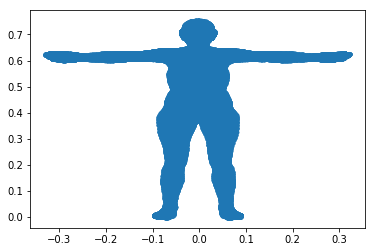

In [19]:
plt.plot(values[100][:,0],values[100][:,1],".")
plt.show()

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
values = np.array(list(map(lambda x: MinMaxScaler().fit_transform(x),values)))

In [22]:
values = values.reshape((values.shape[0],values.shape[1]*values.shape[2]))

In [23]:
values.shape

(450, 201870)

# Reducción de dimensionalidad PCA 

In [24]:
#pca = decomposition.PCA(n_components=350,svd_solver='randomized',whiten=True)
pca = decomposition.PCA(n_components=400,svd_solver='full',whiten=True)
pca.fit(values)
print("Con n_components = {} el valor es: {} ".format(400,pca.explained_variance_ratio_.sum()))

Con n_components = 400 el valor es: 0.9027215985317236 


In [25]:
x_out = pca.transform(values)
x_out.shape

(450, 400)

In [26]:
pca.explained_variance_ratio_[0:2].sum()

0.013228260569024597

In [27]:
def sexo(x):
    if x.find('F') != -1:
        return 'F'
    else:
        return 'M'

In [28]:
sexo_ids = np.array(list(map(lambda x: sexo(x),ids))) 

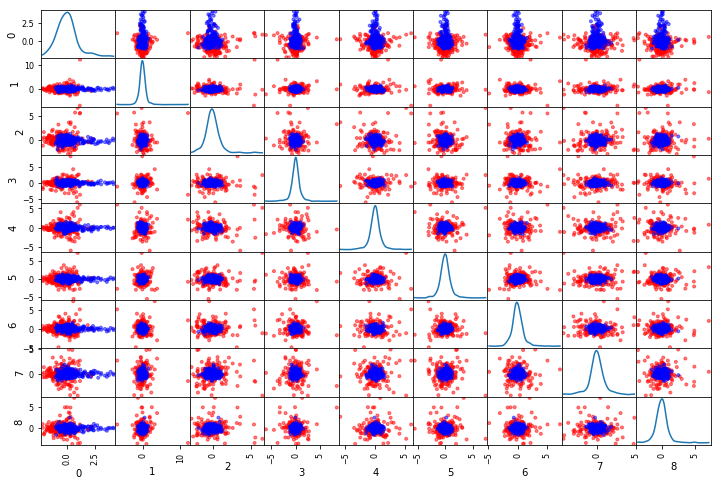

In [29]:
interest_feat = range(10)
data = pd.DataFrame(x_out)
data["labels"]= sexo_ids
color_wheel = {"F": "red", "M": "blue"}
colors = data["labels"].map(lambda x: color_wheel.get(x))
pd.scatter_matrix(data.loc[:,interest_feat[:-1]], figsize=(12,8), diagonal='kde',label=data.loc[:,"labels"],c=colors)
plt.show()

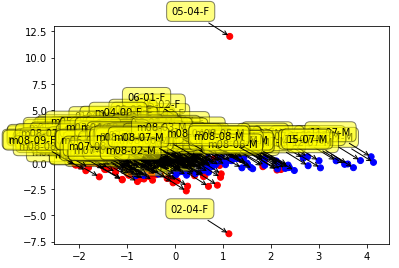

In [41]:
import matplotlib.patches as mpatches
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_out[:,0],x_out[:,1],marker="o",c=colors)
for label, x, y in zip(np.array(ids), x_out[:,0], x_out[:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

# Prediciendo

In [31]:
import sklearn
from sklearn.svm import SVC,LinearSVC

In [32]:
id_sexo = {"F": 0, "M": 1}
sexo_c = list(map(lambda x: id_sexo.get(x),sexo_ids))

In [33]:
X = x_out[:]
y = np.array(sexo_c)

In [34]:
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split( X, y, test_size=0.30, random_state=42)

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
clf_tree = ExtraTreesClassifier(n_estimators=200,
                           max_features=0.3,
                           #max_depth=4, #20
                           random_state=1)
#y_pred = clf.predict(X_test)
#print(classification_report(y_test, y_pred))

In [36]:
clf = SVC(kernel="rbf")

In [37]:
from sklearn.model_selection import StratifiedKFold,cross_val_score
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    print("--- SVC Lineal ---")
    #print(clf.score(X_test,y_test))
    scores = cross_val_score(clf, X, y, cv=10)
    print(classification_report(y_test, clf.predict(X_test)))
    clf_tree.fit(X_train, y_train)
    print("--- Tree ---")
    y_pred = clf_tree.predict(X_test)
    scores = cross_val_score(clf_tree, X, y, cv=10)
    print(scores)
    print(classification_report(y_test, clf_tree.predict(X_test)))

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.53      0.90      0.67       113
          1       0.66      0.19      0.29       112

avg / total       0.59      0.55      0.48       225

--- Tree ---
[ 0.91304348  0.86956522  0.80434783  0.91304348  0.77777778  0.8
  0.81818182  0.88636364  0.93181818  0.79545455]
             precision    recall  f1-score   support

          0       0.88      0.88      0.88       113
          1       0.88      0.88      0.88       112

avg / total       0.88      0.88      0.88       225

--- SVC Lineal ---
             precision    recall  f1-score   support

          0       0.55      0.94      0.69       113
          1       0.77      0.21      0.34       112

avg / total       0.66      0.58      0.51       225

--- Tree ---
[ 0.91304348  0.86956522  0.80434783  0.91304348  0.77777778  0.8
  0.81818182  0.88636364  0.93181818  0.79545455]
             precision    recall  f1-score   support

     

In [38]:
import itertools
from sklearn.metrics import confusion_matrix

Normalized confusion matrix
[[ 0.77876106  0.22123894]
 [ 0.02678571  0.97321429]]


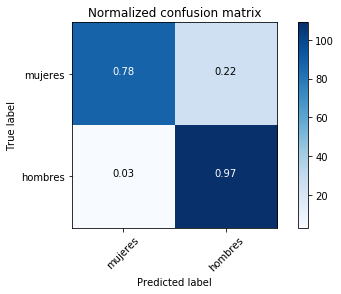

In [39]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["mujeres","hombres"], normalize=True,
                      title='Normalized confusion matrix')
plt.show()